<a href="https://colab.research.google.com/github/Triwka/ml_homework/blob/main/kaggle_comp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
!pip install geopy
!pip install hpsklearn
!pip install optuna
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 154 kB 6.2 MB/s 
  Created wheel for hpsklearn: filename=hpsklearn-0.1.0-py3-none-any.whl size=23913 sha256=2dbfcffe8db9347a52ab8b85aed9f01209c584906888d6b9309fbe37b9cef14f
  Stored in directory: /root/.cache/pip/wheels/ed/78/df/b51d66188f755e2c237b6bcbe8f0ed408e2508eb648814d6fb
Successfully built hpsklearn
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 4.2 MB/s 
     |████████████████████████████████| 209 kB 57.2 MB/s 
     |████████████████████████████████| 81 kB 10.0 MB/s 
     |████████████████████████████████| 78 kB 8.5 MB/s 
     |████████████████████████████████| 50 kB 6.4 MB/s 
     |████████████████████████████████| 147 kB 58.1 MB/s 
     |██████

In [1]:
SEED = 777 #мне повезет

In [105]:
import numpy as np
import pandas as pd
import string
import datetime
import re

from geopy.distance import geodesic
from hpsklearn import HyperoptEstimator
from sklearn.svm import LinearSVC
import optuna
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, average_precision_score
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, roc_auc_score, classification_report, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
import joblib


#импортируем библиотеки matplotlib и seaborn для построения графиков
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


In [28]:
train = pd.read_csv('https://drive.google.com/uc?id=1pVqiPMX7L7bqviBCE-13_uA6ZfBCzOgw', sep=';')
test = pd.read_csv('https://drive.google.com/uc?id=1YtjNEL0Yye6tkW26vpDbfQQv3dZvpSYr', sep=';')
submission = pd.read_csv('https://drive.google.com/uc?id=1MTZnySU5mGdppCp9zq8mg-Of1I_rSai8', sep=';')

Перевод interest_level в цифры


In [29]:
mapper={
        'low':0,
        'medium':1,
        'high':2
       }
train['interest_level'] = train['interest_level'].apply(lambda x: mapper[x])

In [7]:
train.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
0,1.0,0,cb0ecd5356125b546833239efdb154c2,2016-06-02 04:21:46,AMAZING STUDIO!! CONVENIENT TO ALL - G...,Gold Street,"['Cats Allowed', 'Dogs Allowed']",40.6969,7097709,-73.9830,79d1809d224bc7f26c719f247d6c8dc6,['https://photos.renthop.com/2/7097709_8f74305...,2575,257 Gold Street,0
1,1.0,2,4df46d9768a98df24200a2e7693370bd,2016-05-26 05:44:12,"Near NYU, Washington SQ Park, centrally locate...",Thompson Street,[],40.7264,7071860,-74.0013,e60b02e0cfd2eea7d777bb283d6f8d4d,['https://photos.renthop.com/2/7071860_32b196a...,3250,128 Thompson Street,2
2,1.0,0,0,2016-06-17 01:22:32,RENT STABILIZED! FULL TIME DOORMAN.LEXINGTON A...,East 35th Street,"['Doorman', 'Dogs Allowed', 'Cats Allowed']",40.7466,7174524,-73.9779,91a276fdb4c7ae5ff56fd0884b5121db,['https://photos.renthop.com/2/7174524_bde8df9...,2448,165 East 35th Street,0
3,1.0,1,78e50c94b33bb1ceeb5f4c8ff7455703,2016-06-03 05:26:40,WHY TO LIVE IN THIS LUXURIOUS BUILDING? WEEKDA...,West 42nd Street,"['Swimming Pool', 'Roof Deck', 'Dining Room', ...",40.7610,7104515,-73.9992,cbcd513212d592e6c717d27be14f46ac,['https://photos.renthop.com/2/7104515_bab0753...,3300,610 West 42nd Street,0
4,2.0,0,e87f1236b102798c1fa104a372800444,2016-04-12 04:10:28,Listed on the National Register of His...,Greenwich Street,"['Doorman', 'Fitness Center', 'No Fee']",40.7324,6859942,-74.0081,b209e2c4384a64cc307c26759ee0c651,['https://photos.renthop.com/2/6859942_16f88f7...,5450,666 Greenwich Street,0


In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39481 entries, 0 to 39480
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        39481 non-null  float64
 1   bedrooms         39481 non-null  int64  
 2   building_id      39481 non-null  object 
 3   created          39481 non-null  object 
 4   description      38337 non-null  object 
 5   display_address  39376 non-null  object 
 6   features         39481 non-null  object 
 7   latitude         39481 non-null  float64
 8   listing_id       39481 non-null  int64  
 9   longitude        39481 non-null  float64
 10  manager_id       39481 non-null  object 
 11  photos           39481 non-null  object 
 12  price            39481 non-null  int64  
 13  street_address   39472 non-null  object 
 14  interest_level   39481 non-null  int64  
dtypes: float64(3), int64(4), object(8)
memory usage: 4.5+ MB


In [31]:
train.duplicated().sum()

0

In [32]:
train.isna().sum()

bathrooms             0
bedrooms              0
building_id           0
created               0
description        1144
display_address     105
features              0
latitude              0
listing_id            0
longitude             0
manager_id            0
photos                0
price                 0
street_address        9
interest_level        0
dtype: int64

In [33]:
train.description = train.description.fillna('empty')
train = train.dropna().reset_index(drop=True)

## 1.Добавление новых фичей


1)Добавление фичей "количество атрибутов квартиры" и "количество фотографий"

In [34]:
train['num_features']=train['features'].str.replace('[\[\]\']', '').str.split(', ').apply(len)
train['num_photos']=train['photos'].str.replace('[\[\]\']', '').str.split(', ').apply(len)

<ipython-input-34-6a11e9b84264>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train['num_features']=train['features'].str.replace('[\[\]\']', '').str.split(', ').apply(len)
<ipython-input-34-6a11e9b84264>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train['num_photos']=train['photos'].str.replace('[\[\]\']', '').str.split(', ').apply(len)


2)ГИПОТЕЗА:популярость квартиры зависит от её удалённости до какого-либо объекта - добавление фичей "удалённость до какого-либо популярного объекта"

In [35]:
central_park = tuple([40.7736,-73.9727]) #Координаты центрального парка
time_square = tuple([40.7577,-73.9857])  #Координаты тайм-сквера
wall_street = tuple([40.7072,-74.0116])   #Координаты уолл-стрит

In [36]:
train['distance_central_park'] = train.latitude
train['distance_time_square'] = train.latitude
train['distance_wall_street'] = train.latitude

In [37]:
for i in range(train.shape[0]):
  train.distance_central_park.iloc[i] = geodesic((train.latitude.iloc[i],train.longitude.iloc[i]),central_park).miles

for i in range(train.shape[0]):
  train.distance_time_square.iloc[i] = geodesic((train.latitude.iloc[i],train.longitude.iloc[i]),time_square).miles

for i in range(train.shape[0]):
  train.distance_wall_street.iloc[i] = geodesic((train.latitude.iloc[i],train.longitude.iloc[i]),wall_street).miles

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Также из лора гамбургероголовых(осуждаю) можно сказать выдвинуть гипотезы, что популярность квартиры зависит от наличия в шаговой доступности: метро, школы, церкви, удалённость от какого-нибудь гетто, но я не знаю как добавить информацию об этом в датафрейм. С метро можно было бы также с помощью geopy вычислить расстояние до каждой станции и добавлять меньшее для каждого объявления, но станций 450+, а списком их координаты я не нашёл.

3)Некоторые фичи из списка атрибутов квартиры


In [50]:
train['dogs_allowed'] = train.features.apply(lambda x: 1 if 'Dogs Allowed' in x else 0) #разрешены ли собаки
train['cats_allowed'] = train.features.apply(lambda x: 1 if 'Cats Allowed' in x else 0) #разрешены ли кошки
train['doorman'] = train.features.apply(lambda x: 1 if 'Doorman' in x else 0) #есть ли консьерж

In [38]:
train[train.interest_level == 0].price.describe()

count    2.737500e+04
mean     4.067016e+03
std      1.178325e+04
min      4.300000e+01
25%      2.625000e+03
50%      3.300000e+03
75%      4.400000e+03
max      1.150000e+06
Name: price, dtype: float64

In [39]:
train[train.interest_level == 2].price.describe()

count      3080.000000
mean       2692.612338
std        2250.406333
min         700.000000
25%        1850.000000
50%        2400.000000
75%        3104.000000
max      111111.000000
Name: price, dtype: float64

In [40]:
train[train.interest_level == 1].price.describe()

count     8920.000000
mean      3158.442152
std       1247.192766
min        695.000000
25%       2300.000000
50%       2890.000000
75%       3650.000000
max      15000.000000
Name: price, dtype: float64

Из вышеприведенной статистики видно, что средняя цена "горячего" объявления - 2692
(у него и отклонение отличается аж в два раза от остальных, но пока я не знаю какую информацию можно из этого извлечь)

Вообще, надо бы уточнить что из себя представляет interest_level, потому что если это популярность квартиры(считается что человек её очно просмотрел) то цена имеет меньше влияние, а если это популярность объявления(количество кликов на объявление), то цена имеет фактор кликбейта(указать привлекательную-человек заходит, а там сверху надбавки за атрибуты разные коммуналка и проч.)
4)
Следующая фича сгенерирована на основе того, что популярность объявления высчитана путем подсчета количества кликов на объявление


In [41]:
train['price_lower_than_2700'] = train.price.apply(lambda x: 1 if x < 2700 else 0)

5)ГИПОТЕЗА: информация о fee в объявлении также влияет на то кликнет на неё пользователь или нет

In [42]:
#функция для удаления символов пунктуации и цифр
def del_puncdigit(string):
    return ' '.join((re.sub(r'[№"\'_/.:?!\d()%<>;,+#$&\s+]', u' ', string)).lower().split())
               


In [43]:
train['fee_inf'] = train.description.apply(lambda x: 1 if 'fee' in del_puncdigit(x).split() else 0)

6)ГИПОТЕЗА: популярность объявления зависит от менеджера

In [138]:
c00l_managers = train[train.interest_level == 2].manager_id.to_list() #создаем список "крутых менеджеров", у которых "горячие" объявления, чтобы проверять наличие конкретного в этом списке

In [139]:
train['cool_manager'] = train.manager_id.apply(lambda x: 1 if x in c00l_managers else 0)

7)Из базы по рекламе знаю, что постить для большего охвата лучше во время обеда (12:00 - 13:00) либо после работы


In [48]:
train["created"] = pd.to_datetime(train["created"])
train["created_hour"] = train.created.dt.hour

8)Класстеризация по price

In [52]:
pivot_price = pd.pivot_table(train, index = ['listing_id'],  values = 'price')
pivot_price

,price
listing_id,
6811965,2000
6811966,5850
6811975,2400
6812002,3150
6812004,3325
...,...
7731142,6395
7742631,3100
7742670,1750


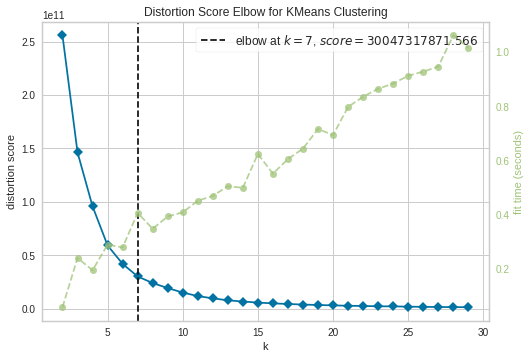

In [83]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(pivot_price)       
visualizer.show()        

Методом локтя вычисляем оптимальное число кластеров для кластеризации по price

In [91]:
model = KMeans(n_clusters = 7, random_state = SEED)
train['price_label'] = model.fit_predict(pivot_price.values)

In [93]:
cat_columns = []
num_columns = []

for column_name in train.columns:
    if (train[column_name].dtypes == object):
        cat_columns +=[column_name]
    else:
        num_columns +=[column_name]

print('Категориальные данные:\t ',cat_columns, '\n Число столблцов = ',len(cat_columns))

print('Числовые данные:\t ',  num_columns, '\n Число столблцов = ',len(num_columns))

Категориальные данные:	  ['building_id', 'description', 'display_address', 'features', 'manager_id', 'photos', 'street_address'] 
 Число столблцов =  7
Числовые данные:	  ['bathrooms', 'bedrooms', 'created', 'latitude', 'listing_id', 'longitude', 'price', 'interest_level', 'num_features', 'num_photos', 'distance_central_park', 'distance_time_square', 'distance_wall_street', 'price_lower_than_2700', 'fee_inf', 'cool_manager', 'created_hour', 'dogs_allowed', 'cats_allowed', 'doorman', 'price_label'] 
 Число столблцов =  21


## 2.Тестирование различных алгоритмов

In [142]:
features = ['bathrooms', 'bedrooms', 'latitude', 'longitude', 'price', 'num_features', 'num_photos', 'distance_central_park', 'distance_time_square', 'distance_wall_street', 'price_lower_than_2700', 'fee_inf', 'cool_manager', 'created_hour', 'dogs_allowed', 'cats_allowed', 'doorman', 'price_label']
target = ['interest_level']

In [143]:
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train[features])

In [144]:
X = scaled_train
y = train[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = SEED, test_size=0.25)

In [146]:
classifiers = {
    'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=3),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=SEED),
    'RandomForestClassifier': RandomForestClassifier(random_state=SEED),
    'MLPClassifier': MLPClassifier(random_state=SEED),
    'AdaBoostClassifier': AdaBoostClassifier(random_state=SEED),
    'GaussianNB': GaussianNB(),
    'QuadraticDiscriminantAnalysis': QuadraticDiscriminantAnalysis(),
    'XGBClassifier': XGBClassifier(random_state=SEED),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=SEED),
    'CatBoostClassifier': CatBoostClassifier(random_seed = SEED),
    'lg': LogisticRegression(random_state = SEED),
    'scv': LinearSVC(random_state = SEED)
}

In [ ]:
df = df = pd.DataFrame(columns=['classifier','f_1','avg_precision_score'])
for name, model in classifiers.items():

    classifier = model
    classifier.fit(X_train, y_train)
    predicts = classifier.predict(X_test)
    f1 = f1_score(y_test, predicts, average='weighted')
    average_precision_score = precision_score(y_test, predicts, average='weighted')
    df = df.append({'classifier': name,'f_1': f1,'avg_precision_score':average_precision_score}, ignore_index=True)
        

In [148]:
df.sort_values(by=['f_1'],ascending = False)

,classifier,f_1,avg_precision_score
9,CatBoostClassifier,0.722695,0.716609
2,RandomForestClassifier,0.700387,0.691311
8,GradientBoostingClassifier,0.691209,0.696101
3,MLPClassifier,0.690092,0.683092
7,XGBClassifier,0.676690,0.681768
4,AdaBoostClassifier,0.675505,0.671088
1,DecisionTreeClassifier,0.661938,0.661599
0,KNeighborsClassifier,0.631685,0.615574
10,lg,0.630714,0.631092
11,scv,0.605218,0.578807


Удалим сильно коррелирующие между собой признаки и повторим

In [141]:
cm = sns.color_palette("vlag", as_cmap=True)

train[features].corr().style.background_gradient(cmap=cm, vmin = -1, vmax=1)

,bathrooms,bedrooms,latitude,longitude,price,num_features,num_photos,distance_central_park,distance_time_square,distance_wall_street,price_lower_than_2700,fee_inf,cool_manager,created_hour,dogs_allowed,cats_allowed,doorman,price_label
bathrooms,1.000000,0.536817,-0.010906,0.011672,0.158662,0.227551,0.150899,0.011940,0.012357,0.013424,-0.284362,0.043216,-0.037252,-0.011625,0.025137,0.020724,0.162634,-0.005351
bedrooms,0.536817,1.000000,-0.005036,0.007203,0.111619,0.133989,0.157480,0.006998,0.007310,0.006850,-0.444061,0.092703,0.043358,0.037268,-0.002755,-0.005295,-0.036860,0.002001
latitude,-0.010906,-0.005036,1.000000,-0.969669,-0.001460,0.001151,-0.008281,-0.988835,-0.988389,-0.987105,0.007465,-0.008270,0.004627,-0.041392,-0.006337,-0.008072,0.003452,0.010957
longitude,0.011672,0.007203,-0.969669,1.000000,0.000436,-0.007887,0.005713,0.942431,0.942607,0.942776,0.003149,0.005711,-0.007996,0.035453,0.004724,0.006874,-0.012217,-0.011986
price,0.158662,0.111619,-0.001460,0.000436,1.000000,0.054254,0.025534,0.000866,0.000726,0.000860,-0.112179,0.000806,-0.029017,-0.008533,0.021395,0.018675,0.066082,-0.002866
num_features,0.227551,0.133989,0.001151,-0.007887,0.054254,1.000000,0.151730,-0.003833,-0.005294,-0.006248,-0.284667,0.232053,0.097008,-0.004397,0.312786,0.301433,0.597351,-0.010449
num_photos,0.150899,0.157480,-0.008281,0.005713,0.025534,0.151730,1.000000,0.006551,0.006018,0.004109,-0.125091,0.073907,0.035664,0.064305,0.070140,0.079395,0.029495,-0.008640
distance_central_park,0.011940,0.006998,-0.988835,0.942431,0.000866,-0.003833,0.006551,1.000000,0.999943,0.999436,0.002287,0.007837,-0.005094,0.037628,0.005120,0.006752,-0.010987,-0.010013
distance_time_square,0.012357,0.007310,-0.988389,0.942607,0.000726,-0.005294,0.006018,0.999943,1.000000,0.999681,0.004634,0.007626,-0.005560,0.036977,0.004513,0.006265,-0.012894,-0.010027
distance_wall_street,0.013424,0.006850,-0.987105,0.942776,0.000860,-0.006248,0.004109,0.999436,0.999681,1.000000,0.006433,0.008745,-0.006153,0.033978,0.002576,0.004584,-0.013285,-0.010208


In [156]:
target = ['interest_level']
features_clean = ['bathrooms', 'bedrooms', 'price', 'num_features', 'num_photos', 'distance_central_park', 'price_lower_than_2700', 'fee_inf', 'cool_manager', 'created_hour', 'dogs_allowed', 'doorman', 'price_label']

In [158]:
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train[features_clean])

In [160]:
X = scaled_train
y = train[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = SEED, test_size=0.25)

In [ ]:
df_clean = pd.DataFrame(columns=['classifier','f_1','avg_precision_score'])
for name, model in classifiers.items():

    classifier = model
    classifier.fit(X_train, y_train)
    predicts = classifier.predict(X_test)
    f1 = f1_score(y_test, predicts, average='weighted')
    average_precision_score = precision_score(y_test, predicts, average='weighted')
    df_clean = df_clean.append({'classifier': name,'f_1': f1,'avg_precision_score':average_precision_score}, ignore_index=True)

In [162]:
df_clean.sort_values(by=['f_1'],ascending = False)

,classifier,f_1,avg_precision_score
9,CatBoostClassifier,0.705387,0.699874
2,RandomForestClassifier,0.690994,0.683165
3,MLPClassifier,0.687069,0.676399
8,GradientBoostingClassifier,0.683084,0.686856
7,XGBClassifier,0.668091,0.676069
4,AdaBoostClassifier,0.661057,0.655398
1,DecisionTreeClassifier,0.655227,0.656637
0,KNeighborsClassifier,0.631770,0.615598
10,lg,0.626274,0.625896
11,scv,0.603582,0.579518


Видно, что f1 упал, => оставляем все созданные ранее признаки

## 3. Отбор признаков

In [253]:
X = train[features]
y = train[target]

In [254]:
clf = CatBoostClassifier(random_seed = SEED)
clf = clf.fit(X, y)

Learning rate set to 0.095429
0:	learn: 1.0281571	total: 33.1ms	remaining: 33.1s
1:	learn: 0.9723480	total: 57.1ms	remaining: 28.5s
2:	learn: 0.9267730	total: 82ms	remaining: 27.2s
3:	learn: 0.8878671	total: 108ms	remaining: 26.9s
4:	learn: 0.8568283	total: 135ms	remaining: 26.9s
5:	learn: 0.8299537	total: 159ms	remaining: 26.3s
6:	learn: 0.8066219	total: 185ms	remaining: 26.3s
7:	learn: 0.7864972	total: 216ms	remaining: 26.7s
8:	learn: 0.7689667	total: 240ms	remaining: 26.4s
9:	learn: 0.7542391	total: 265ms	remaining: 26.2s
10:	learn: 0.7411932	total: 293ms	remaining: 26.3s
11:	learn: 0.7310214	total: 314ms	remaining: 25.9s
12:	learn: 0.7217900	total: 341ms	remaining: 25.9s
13:	learn: 0.7122080	total: 364ms	remaining: 25.7s
14:	learn: 0.7039017	total: 391ms	remaining: 25.7s
15:	learn: 0.6967127	total: 421ms	remaining: 25.9s
16:	learn: 0.6899127	total: 448ms	remaining: 25.9s
17:	learn: 0.6841541	total: 473ms	remaining: 25.8s
18:	learn: 0.6780505	total: 497ms	remaining: 25.6s
19:	learn:

In [255]:
clf.feature_importances_ 

array([ 1.49399144,  9.04361184,  4.17840217,  6.23180739, 17.58679281,
        6.44807401,  5.832582  ,  3.86433547,  4.98515623,  5.26269012,
        0.88126624,  1.26489945, 22.13685491,  6.5444568 ,  0.90425141,
        0.87169085,  0.88298529,  1.58615157])

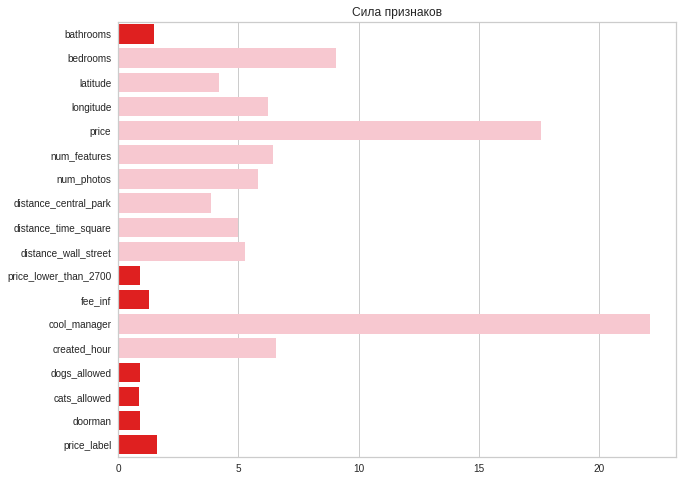

In [257]:
values = clf.feature_importances_   
idx = features
plt.figure(figsize=(10,8))
clrs = ['pink' if x > 3 else 'red' for x in values ]
sns.barplot(y=idx,x=values,palette=clrs).set(title='Сила признаков')
plt.show()

In [258]:
strong_features = []
for key,value in dict(zip(features, clf.feature_importances_ )).items():
  if value > 3:
    strong_features.append(key)
strong_features

['bedrooms',
 'latitude',
 'longitude',
 'price',
 'num_features',
 'num_photos',
 'distance_central_park',
 'distance_time_square',
 'distance_wall_street',
 'cool_manager',
 'created_hour']

In [259]:
X.longitude = X.longitude.apply(lambda x: - x)

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [260]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=11)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
strong_features_2 = featureScores.nlargest(11,'Score').Specs.values.tolist()
strong_features_2

['price',
 'distance_time_square',
 'distance_wall_street',
 'created_hour',
 'distance_central_park',
 'cool_manager',
 'price_lower_than_2700',
 'num_features',
 'fee_inf',
 'doorman',
 'dogs_allowed']

<ipython-input-261-0b384182c407>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  extra_tree_forest.fit(X, y)


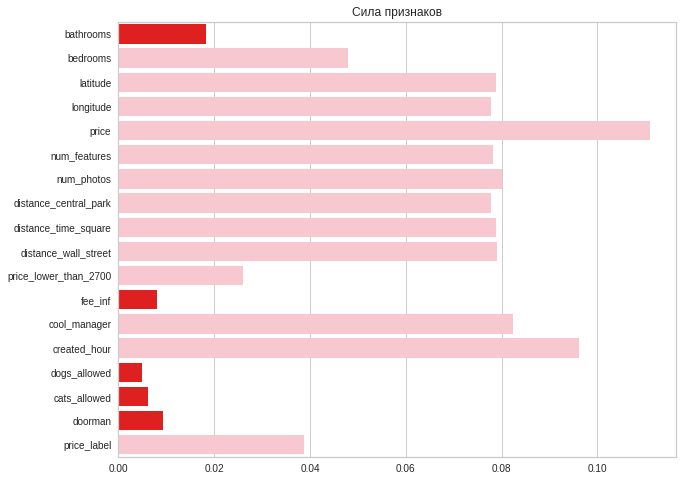

In [261]:
from sklearn.ensemble import ExtraTreesClassifier
extra_tree_forest = ExtraTreesClassifier(n_estimators = 5,
                                        criterion ='entropy', max_features = 2)
  
extra_tree_forest.fit(X, y)
feature_importance = extra_tree_forest.feature_importances_

values = feature_importance   
idx = features
plt.figure(figsize=(10,8))
clrs = ['pink' if x > 0.02 else 'red' for x in values ]
sns.barplot(y=idx,x=values,palette=clrs).set(title='Сила признаков')
plt.show()

In [262]:
strong_features_3 = [key for key,values in dict(zip(features, feature_importance)).items() if values > 0.02]
strong_features_3

['bedrooms',
 'latitude',
 'longitude',
 'price',
 'num_features',
 'num_photos',
 'distance_central_park',
 'distance_time_square',
 'distance_wall_street',
 'price_lower_than_2700',
 'cool_manager',
 'created_hour',
 'price_label']

In [271]:
from sklearn.feature_selection import RFE
selector = RFE(RandomForestClassifier(random_state=SEED), n_features_to_select=10, step=1)
selector = selector.fit(X, np.ravel(y))
selector.ranking_


array([8, 3, 1, 1, 1, 1, 1, 1, 1, 1, 5, 6, 1, 1, 7, 4, 9, 2])

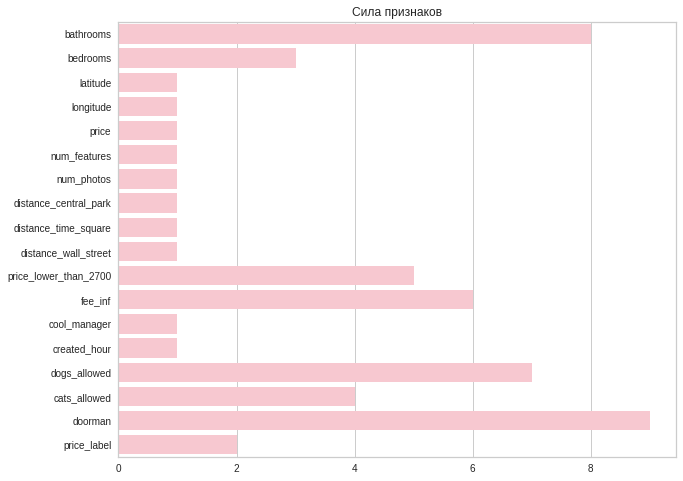

In [272]:
values = selector.ranking_   
idx = features
plt.figure(figsize=(10,8))
#clrs = ['pink' if x > 0.02 else 'red' for x in values ]
sns.barplot(y=idx,x=values,palette=clrs).set(title='Сила признаков')
plt.show()

In [273]:
strong_features_4 = [key for key,values in dict(zip(features, selector.ranking_ )).items() if values > 2]
strong_features_4

['bathrooms',
 'bedrooms',
 'price_lower_than_2700',
 'fee_inf',
 'dogs_allowed',
 'cats_allowed',
 'doorman']

In [280]:
features_list = {'str_features':strong_features,'strong_features_2':strong_features_2,'strong_features_3':strong_features_3,'strong_features_4':strong_features_4}

In [281]:
total_df = pd.DataFrame(columns=['classifier','f_1','avg_precision_score'])
for name, model in classifiers.items():
    for key,value in features_list.items():
      scaled_train = scaler.fit_transform(train[value])
      X = scaled_train
      y = train[target]
      X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = SEED, test_size=0.25)
      classifier = model
      classifier.fit(X_train, y_train)
      predicts = classifier.predict(X_test)
      f1 = f1_score(y_test, predicts, average='weighted')
      average_precision_score = precision_score(y_test, predicts, average='weighted')
      total_df = total_df.append({'classifier': name + '_' + key,'f_1': f1,'avg_precision_score':average_precision_score}, ignore_index=True)

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-pa

Learning rate set to 0.094039
0:	learn: 1.0294671	total: 25.2ms	remaining: 25.2s
1:	learn: 0.9734917	total: 44.9ms	remaining: 22.4s
2:	learn: 0.9300146	total: 63.8ms	remaining: 21.2s
3:	learn: 0.8938179	total: 80.8ms	remaining: 20.1s
4:	learn: 0.8627015	total: 99.7ms	remaining: 19.8s
5:	learn: 0.8364502	total: 118ms	remaining: 19.6s
6:	learn: 0.8126438	total: 141ms	remaining: 19.9s
7:	learn: 0.7928376	total: 159ms	remaining: 19.7s
8:	learn: 0.7751623	total: 177ms	remaining: 19.5s
9:	learn: 0.7603445	total: 198ms	remaining: 19.6s
10:	learn: 0.7479740	total: 216ms	remaining: 19.4s
11:	learn: 0.7348535	total: 235ms	remaining: 19.3s
12:	learn: 0.7241306	total: 253ms	remaining: 19.2s
13:	learn: 0.7146644	total: 271ms	remaining: 19.1s
14:	learn: 0.7066643	total: 289ms	remaining: 19s
15:	learn: 0.6997114	total: 308ms	remaining: 18.9s
16:	learn: 0.6928173	total: 326ms	remaining: 18.9s
17:	learn: 0.6863808	total: 345ms	remaining: 18.8s
18:	learn: 0.6809782	total: 362ms	remaining: 18.7s
19:	lear

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

In [283]:
total_df.sort_values(by='f_1',ascending=False)

,classifier,f_1,avg_precision_score
36,CatBoostClassifier_str_features,0.716535,0.709538
38,CatBoostClassifier_strong_features_3,0.712680,0.705226
8,RandomForestClassifier_str_features,0.703283,0.694566
10,RandomForestClassifier_strong_features_3,0.702037,0.693097
32,GradientBoostingClassifier_str_features,0.692382,0.697070
34,GradientBoostingClassifier_strong_features_3,0.691275,0.695952
14,MLPClassifier_strong_features_3,0.689588,0.686349
37,CatBoostClassifier_strong_features_2,0.682938,0.680494
12,MLPClassifier_str_features,0.682836,0.678464
9,RandomForestClassifier_strong_features_2,0.682523,0.671761


Catboost wins!
PREDICTALITY!!!